# Machine Learning on Walking Activity Detection in PD patients

## 0. Initialization

### 0.1 Imports

In [39]:
import pandas as pd
import numpy as np
import glob
from src.signal_processing import *
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
import os

### 0.2 Functions

In [2]:
def resample_data(df, frequency):
    dx = np.zeros(len(df))
    dy = np.zeros(len(df))
    dz = np.zeros(len(df))
    xSlope = np.zeros(len(df))
    ySlope = np.zeros(len(df))
    zSlope = np.zeros(len(df))
    xIntercept = np.zeros(len(df))
    yIntercept = np.zeros(len(df))
    zIntercept = np.zeros(len(df))

    new_x = []
    new_y = []
    new_z = []

    for i in range(1, len(df)):
        dtime = df.loc[i, 0] - df.loc[i-1, 0]
        dx[i] = df.loc[i, 1] - df.loc[i-1, 1]
        dy[i] = df.loc[i, 2] - df.loc[i-1, 2]
        dz[i] = df.loc[i, 3] - df.loc[i-1, 3]
        xSlope[i] = dx[i] / dtime
        ySlope[i] = dy[i] / dtime
        zSlope[i] = dz[i] / dtime
        xIntercept[i] = df.loc[i, 1]
        yIntercept[i] = df.loc[i, 2]
        zIntercept[i] = df.loc[i, 3]

    df_new = pd.DataFrame()

    time = list(np.around(np.arange(df.loc[0,0], df.loc[len(df)-1, 0], 1/frequency), 2))

    best_j = 0
    for i in range(len(time)):
        best_value = float("inf")
        j = best_j
        for _ in range(15):
            if j == len(df):
                break
            diff = df.loc[j, 0] - time[i]
            if diff > 0.15:
                break

            if abs(diff) < best_value:
                best_value = abs(diff)
                best_j = j
            j+=1
        timeI = time[i] - df.loc[best_j, 0]

        best_value = df.loc[best_j, 0] - time[i]
        new_x.append(xSlope[best_j] * best_value + xIntercept[best_j])
        new_y.append(ySlope[best_j] * best_value + yIntercept[best_j])
        new_z.append(zSlope[best_j] * best_value + zIntercept[best_j])
    
    df_new[0] = time
    df_new[1] = new_x
    df_new[2] = new_y
    df_new[3] = new_z
    return df_new

import pandas as pd
import numpy as np
from scipy import signal


def butter_bandpass(cut, fs, order, btype):
    """
    A function which created a filter. It can be a bandpass,
    lowpass or highpass filter to apply for signal.
    It makes use of the signal class of the scipy package.
        *cut: frequency value which will serve to cut the signal
        *fs: frequency of the signal
        *order: from 1 to N it changes the way the signal is filtered
        *btype: 'bandpass', 'low' or 'high'
    """
    nyq = 0.5 * fs
    high_low = cut / nyq
    b, a = signal.butter(order, high_low, btype)
    return b, a


def butter_bandpass_filter(data, cut, fs, order=4, btype="low"):
    """
    This function employs the butter_bandpass to a dataset.
    It has some default values which are mainly used in this project.
    """
    b, a = butter_bandpass(cut, fs, order, btype)
    y = signal.filtfilt(b, a, data)
    return y


def butter_bp_data(data, lower_than, fs, order, btype):
    """
    This function applies the bandpass to a dataset
    with 4 dimensions, supposing that the 1st is the time dimension.
    """
    for i in range(1, 4):
        data[i] = butter_bandpass_filter(data[i], lower_than, fs, order, btype)
    return data


def applyOffsetRemove(df):
    df[1] = np.subtract(df[1], np.average(df[1]))
    df[2] = np.subtract(df[2], np.average(df[2]))
    df[3] = np.subtract(df[3], np.average(df[3]))

## 1 Processing data

This section will consist of several parts

+ Resample the data to 10Hz (Check)
+ The data must start at first timestamp and stop at last timestamp (Check)
+ Analysing if data should be normalized
+ Data goes to .csv and anonimized

To start I open the Timestamps CSV which contains the timestamps of start and end when the patient was walking.

In [272]:
file_ts = "data/timestamps/TS@P1.csv"

df_ts = pd.read_csv(file_ts)

start = df_ts.loc[0, 'Timestamp S']
end = df_ts.loc[len(df_ts)-1, 'Timestamp E']

df_ts.head()

,Timestamp S,Timestamp E,From,To,Seconds S,Seconds E
0,1561983739,1561983747,00:02:21,00:02:29,0,8
1,1561983768,1561983776,00:02:50,00:02:58,29,8
2,1561983784,1561983791,00:03:06,00:03:13,45,7
3,1561983807,1561983817,00:03:29,00:03:39,68,10
4,1561983831,1561983842,00:03:53,00:04:04,92,11


The only values we want from this CSV are the 'Timestamp S' and 'Timestamp E'. They are the timestamps for starting and ending a walking segment.

I will load the dataset for patient 1, resample it to 10Hz instead of 100Hz and cut the DataFrame on the starting timestamp and ending timestamp since there might exist movements associated with walking that were not observed in the timestamps CSV.

In [273]:
file = file_ts.split("@")[1]
df = pd.read_csv("data/" + file, header=None)
df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
df = resample_data(df, 10)

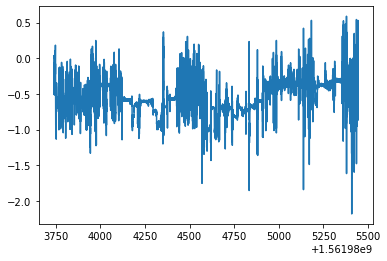

In [274]:
plt.plot(df[0], df[1])

As we can see there is a lot of noise in the data, including the effect of gravity on this axis, justifying why the data is centered around -0.5g.

To improve the data for classification, we remove this offset and apply a Butterworth filter to eliminate all movements above 0.5Hz. By applying this filter we are not allowing for the detection of any step that takes more than 2 seconds.

In [275]:
applyOffsetRemove(df)
df = butter_bp_data(df, 0.5, 10, 4, 'high')

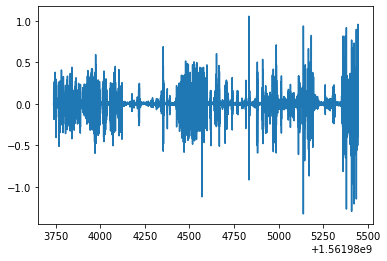

In [276]:
plt.plot(df[0], df[1])

In [277]:
# What are the max and the minimum values of this dataset?

print(f"Maximum value for x-axis is: {df[1].quantile(0.999):.3}")
print(f"Minimum value for x-axis is: {df[1].quantile(0.001):.3}")
print(f"Maximum value for y-axis is: {df[2].quantile(0.999):.3}")
print(f"Minimum value for y-axis is: {df[2].quantile(0.001):.3}")
print(f"Maximum value for z-axis is: {df[3].quantile(0.999):.3}")
print(f"Minimum value for z-axis is: {df[3].quantile(0.001):.3}")

Maximum value for x-axis is: 0.661
Minimum value for x-axis is: -0.598
Maximum value for y-axis is: 0.671
Minimum value for y-axis is: -0.504
Maximum value for z-axis is: 0.567
Minimum value for z-axis is: -0.573


To understand if it is needed to normalize the data, the max and min values will be compared across 4 datasets. The first one is above, but I will check as well for 3 more files: P2, P3, P5.

In [173]:
def check_max_min_values(*args):
    for arg in args:
        file_ts = "data/timestamps/TS@" + arg + ".csv"
        df_ts = pd.read_csv(file_ts)
        start = df_ts.loc[0, 'Timestamp S']
        end = df_ts.loc[len(df_ts)-1, 'Timestamp E']
        file = file_ts.split("@")[1]
        df = pd.read_csv("data/" + file, header=None)
        df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
        df = resample_data(df, 10)
        applyOffsetRemove(df)
        df = butter_bp_data(df, 0.5, 10, 4, 'high')
        print(f"Maximum value for {arg} x-axis is: {df[1].quantile(0.999):.3}")
        print(f"Minimum value for {arg} x-axis is: {df[1].quantile(0.001):.3}")
        print(f"Maximum value for {arg} y-axis is: {df[2].quantile(0.999):.3}")
        print(f"Minimum value for {arg} y-axis is: {df[2].quantile(0.001):.3}")
        print(f"Maximum value for {arg} z-axis is: {df[3].quantile(0.999):.3}")
        print(f"Minimum value for {arg} z-axis is: {df[3].quantile(0.001):.3}")

In [174]:
files = ["P2", "P3", "P5"]
check_max_min_values(*files)

Maximum value for P2 x-axis is: 0.421
Minimum value for P2 x-axis is: -0.41
Maximum value for P2 y-axis is: 0.376
Minimum value for P2 y-axis is: -0.454
Maximum value for P2 z-axis is: 0.377
Minimum value for P2 z-axis is: -0.394
Maximum value for P3 x-axis is: 0.507
Minimum value for P3 x-axis is: -0.52
Maximum value for P3 y-axis is: 0.327
Minimum value for P3 y-axis is: -0.362
Maximum value for P3 z-axis is: 0.467
Minimum value for P3 z-axis is: -0.424
Maximum value for P5 x-axis is: 0.521
Minimum value for P5 x-axis is: -0.67
Maximum value for P5 y-axis is: 0.516
Minimum value for P5 y-axis is: -0.616
Maximum value for P5 z-axis is: 0.52
Minimum value for P5 z-axis is: -0.377


Data seems to not need any normalization since it is varying always between -0.5 and 0.5 in all the 3 axis. To get these values a quantile of 99.9 and 0.1 were used in order to leave out the outlier movements.

## 2. Preparing Dataset for Classifiers

To add to our data processing we also add a new feature, a combined standard deviation computed using a rolling window of 2 seconds. And we also include lag features, with values back and forth in time. 

In [266]:
def add_cmb_std(df, window = 10):
    data_combined1 = df[1].rolling(window, center=True).std()
    data_combined2 = df[2].rolling(window, center=True).std()
    data_combined3 = df[3].rolling(window, center=True).std()
    arr = np.array([
        data_combined1.tolist(),
        data_combined2.tolist(),
        data_combined3.tolist()
        ])
    data_combined = arr.sum(axis = 0)

    df["combinedSTD"] = data_combined
    return df


def add_target(df, df_ts):
    for i in df_ts.index:
        start, end = df_ts.loc[i,['Timestamp S', 'Timestamp E']].values
        df[f"target {i}"] = df[0].apply(lambda x: 1 if ((x > start) & (x < end)) else 0)
    df["target"] = df.loc[:,"target 0":f"target {len(df_ts)-1}"].sum(axis=1)
    columns = [0, 1, 2, 3, 'combinedSTD', "target"]
    return df[columns]
    

def create_X_y(df, window = 20):
    X = np.full((len(df[0]),1+int(3*window/4)*3), -50, dtype=float)

    for i in range(int(window/2), len(df)-int(window/2)):
        temp_list = list(df[[1,2,3]].loc[i,:])+\
            [df.loc[i,'combinedSTD']]+\
            df[[1, 2, 3]][int(i-window/2):i].values.reshape(1,-1).tolist()[0]+\
            df[[1, 2, 3]][i+1:int(i+window/4)].values.reshape(1,-1).tolist()[0]
        temp_array = np.asarray(temp_list)
        X[i] = temp_array

    y = np.asmatrix(df['target']).T
    data = np.hstack((X,y))
    data = data[int(window/2):-int(window/2)]
    return data

In [255]:
df = add_cmb_std(df, 10)
df['combinedSTD'].head(10)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5    0.555975
6    0.585447
7    0.467569
8    0.441756
9    0.378914
Name: combinedSTD, dtype: float64

In [256]:
df = add_target(df)
df.head()

,0,1,2,3,combinedSTD,target
0,1.559661e+09,-0.000849,-0.000197,-0.002196,NaN,0
1,1.559661e+09,-0.276687,-0.827281,-0.375365,NaN,1
2,1.559661e+09,-0.101022,-0.628911,-0.206501,NaN,1
3,1.559661e+09,-0.102140,-0.376279,-0.202667,NaN,1
4,1.559661e+09,-0.095422,-0.196530,-0.113456,NaN,1


In [257]:
df['target'].value_counts()

0    10462
1     2828
Name: target, dtype: int64

In [258]:
df = create_X_y(df, 20)

In [261]:
print(f"This dataset has {df.shape[0]} entries and {df.shape[1]} features")

This dataset has 13270 entries and 47 features


### 2.1 Preparing files for all patients

In [264]:
files = [f"P{n}" for n in range(1,17)]
files.remove("P4") # Had to be removed due to problems in timestamps
files

['P1',
 'P2',
 'P3',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16']

In [267]:
def process_data(*args):
    for arg in args:
        df_path = os.path.join("data", f"{arg}_p.npy")
        if not os.path.isfile(df_path):
            file_ts = "data/timestamps/TS@" + arg + ".csv"
            df_ts = pd.read_csv(file_ts)
            start = df_ts.loc[0, 'Timestamp S']
            end = df_ts.loc[len(df_ts)-1, 'Timestamp E']
            file = file_ts.split("@")[1]
            df = pd.read_csv("data/" + file, header=None)
            df = df[(df[0] > start) & (df[0] < end)].reset_index(drop=True)
            df = resample_data(df, 10)
            applyOffsetRemove(df)
            df = butter_bp_data(df, 0.5, 10, 4, 'high')
            df = add_cmb_std(df, 10)
            df = add_target(df, df_ts)
            df = create_X_y(df, 20)
            np.save(df_path, df)
            print(f"Dataset {arg} has {df.shape[0]} entries and {df.shape[1]-1} features")
        else:
            df = np.load(df_path)
            print(f"Dataset {arg} has {df.shape[0]} entries and {df.shape[1]-1} features")

In [268]:
process_data(*files)

Dataset P1 has 17040 entries and 46 features
Dataset P2 has 13270 entries and 46 features
Dataset P3 has 10210 entries and 46 features
Dataset P5 has 11710 entries and 46 features
Dataset P6 has 16440 entries and 46 features
Dataset P7 has 19390 entries and 46 features
Dataset P8 has 13810 entries and 46 features
Dataset P9 has 16820 entries and 46 features
Dataset P10 has 21890 entries and 46 features
Dataset P11 has 28140 entries and 46 features
Dataset P12 has 12000 entries and 46 features
Dataset P13 has 19540 entries and 46 features
Dataset P14 has 18670 entries and 46 features
Dataset P15 has 15210 entries and 46 features
Dataset P16 has 7640 entries and 46 features


### 2.1 Checking results

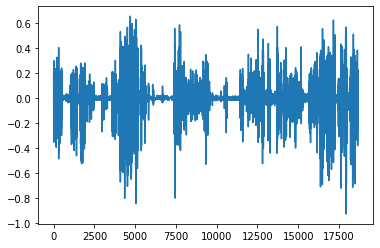

In [320]:
data = np.load('data/P14_p.npy')
plt.plot(list(range(len(data))), data[:,1])

In [321]:
print('Resampled dataset shape %s' % Counter(data[:,-1]))

Resampled dataset shape Counter({0.0: 14541, 1.0: 4129})


## 3. Loading Data

In [3]:
p1 = np.load("data/P1_p.npy")
p2 = np.load("data/P2_p.npy")
p3 = np.load("data/P3_p.npy")
p5 = np.load("data/P5_p.npy")
p6 = np.load("data/P6_p.npy")
p7 = np.load("data/P7_p.npy")
p8 = np.load("data/P8_p.npy")
p9 = np.load("data/P9_p.npy")
p10 = np.load("data/P10_p.npy")
p11 = np.load("data/P11_p.npy")
p12 = np.load("data/P12_p.npy")
p13 = np.load("data/P13_p.npy")
p14 = np.load("data/P14_p.npy")
p15 = np.load("data/P15_p.npy")
p16 = np.load("data/P16_p.npy")

### 3.1 Concatenating Training and Test set

In [4]:
def train_test_Xy(train_tuple, test_tuple):
    data_train = np.empty(47, dtype=float).reshape(1,-1)
    data_test = np.empty(47, dtype=float).reshape(1,-1)
    for array in train_tuple:
        data_train = np.concatenate((data_train, array))
    for array in test_tuple:
        data_test = np.concatenate((data_test, array))
    return data_train[1:], data_test[1:]

In [22]:
data_train, data_test = train_test_Xy((p1, p2, p3, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16), (p5, p6))

In [23]:
data_train.shape

(213630, 47)

In [24]:
data_test.shape

(28150, 47)

## 4. Balancing the Data

We have unbalanced data so an undersampling is under way. RandomUnderSampler will be used since we want a well distributed increase in number of samples.

In [25]:
print('Original dataset shape %s' % Counter(data_train[:,-1]))

Original dataset shape Counter({0.0: 178447, 1.0: 35183})


In [26]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(data_train[:,:-1], data_train[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0.0: 35183, 1.0: 35183})


## 5. Applying a Time Lagged Feed Forward Network to a training and test set

Train on 56292 samples, validate on 14074 samples
Epoch 1/50
56292/56292 [==============================] - 3s 45us/step - loss: 0.4199 - accuracy: 0.7967 - val_loss: 1.0335 - val_accuracy: 0.4297
Epoch 2/50
56292/56292 [==============================] - 3s 46us/step - loss: 0.3553 - accuracy: 0.8406 - val_loss: 0.8494 - val_accuracy: 0.4957
Epoch 3/50
56292/56292 [==============================] - 3s 45us/step - loss: 0.3262 - accuracy: 0.8563 - val_loss: 1.0081 - val_accuracy: 0.4338
Epoch 4/50
56292/56292 [==============================] - 3s 45us/step - loss: 0.3008 - accuracy: 0.8698 - val_loss: 1.0211 - val_accuracy: 0.4728
Epoch 5/50
56292/56292 [==============================] - 3s 46us/step - loss: 0.2787 - accuracy: 0.8807 - val_loss: 0.9327 - val_accuracy: 0.5523
Epoch 6/50
56292/56292 [==============================] - 3s 45us/step - loss: 0.2585 - accuracy: 0.8906 - val_loss: 1.0455 - val_accuracy: 0.5073
Epoch 7/50
56292/56292 [==============================] - 3s 45us/st

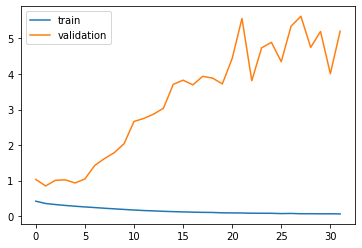

In [65]:
model = Sequential()
model.add(Dense(200, input_shape=(46,), activation='relu'))
model.add(Dense(200, input_shape=(200,), activation='relu'))
model.add(Dense(200, input_shape=(200,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    'adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model.fit(
    x=np.array(X_res),
    y=np.array(y_res),
    batch_size=30,
    epochs=50,
    verbose=1,
    validation_split=0.2,
    callbacks=[es, mc]
)

model = load_model('models/best_model.h5')

# evaluate the model
_, train_acc = model.evaluate(X_res, y_res, verbose=0)
_, test_acc = model.evaluate(data_test[:,:-1], data_test[:,-1], verbose=0)
print('\n\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### Testing

In [66]:
from sklearn.metrics import classification_report

y_pred = model.predict(data_test[:,:-1], batch_size=50, verbose=1)
y_pred_bool = np.around(y_pred, decimals=0)

print(classification_report(data_test[:,-1], y_pred_bool))

28150/28150 [==============================] - 0s 8us/step
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     22360
         1.0       0.61      0.81      0.69      5790

    accuracy                           0.85     28150
   macro avg       0.78      0.84      0.80     28150
weighted avg       0.88      0.85      0.86     28150



### Benchmarking with LogisticRegression

In [67]:
from sklearn.linear_model import LogisticRegression

your_model = LogisticRegression(max_iter=1000, random_state=42)
your_model.fit(X_res[:,3].reshape(-1, 1), y_res)
y_pred = your_model.predict(data_test[:,3].reshape(-1 ,1))

print(classification_report(data_test[:,-1], y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90     22360
         1.0       0.59      0.87      0.70      5790

    accuracy                           0.85     28150
   macro avg       0.77      0.86      0.80     28150
weighted avg       0.88      0.85      0.86     28150



We can notice that using just the Combined Standard deviation can bring a better recall, though the precision seems to be better by using our TLFFN.